In [1]:
import torch,torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import pandas as pd
import wandb
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
PROJECT_NAME = 'Microcontroller-Detection-Learning-Detectron2'

In [2]:
data = pd.read_csv('./train_labels.csv').append(pd.read_csv('./test_labels.csv')).sample(frac=1)

In [3]:
data

,filename,width,height,class,xmin,ymin,xmax,ymax
121,IMG_20190104_164125.jpg,800,600,Arduino_Nano,356,225,514,356
15,IMG_20181228_102317.jpg,800,600,Heltec_ESP32_Lora,389,271,543,398
30,IMG_20181228_103009.jpg,800,600,Heltec_ESP32_Lora,203,210,561,401
55,IMG_20181228_103828.jpg,800,600,Raspberry_Pi_3,100,129,590,511
154,IMG_20190104_164622.jpg,800,600,Arduino_Nano,569,121,691,267
...,...,...,...,...,...,...,...,...
110,IMG_20190104_163951.jpg,800,600,Raspberry_Pi_3,4,29,449,467
8,IMG_20181228_102048.jpg,800,600,Heltec_ESP32_Lora,457,198,553,287
61,IMG_20181228_104139.jpg,800,600,Raspberry_Pi_3,1,45,773,579
111,IMG_20190104_163951.jpg,800,600,ESP8266,358,336,656,537


In [4]:
xmin,ymin,xmax,ymax = 317,265,556,342
x = xmin
y = ymin
w = xmax - xmin
h = ymax - ymin

In [5]:
img = cv2.imread('./data/IMG_20181228_101826.jpg')

In [6]:
crop = img[y:y+h,x:x+w]

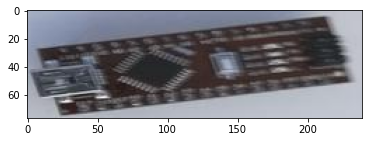

In [7]:
plt.imshow(crop)

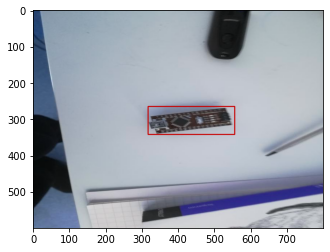

In [8]:
plt.imshow(cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2))

In [9]:
cv2.imwrite('./box.png',cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2))

True

In [10]:
cv2.imwrite('./crop.png',crop)

True

In [11]:
data

,filename,width,height,class,xmin,ymin,xmax,ymax
121,IMG_20190104_164125.jpg,800,600,Arduino_Nano,356,225,514,356
15,IMG_20181228_102317.jpg,800,600,Heltec_ESP32_Lora,389,271,543,398
30,IMG_20181228_103009.jpg,800,600,Heltec_ESP32_Lora,203,210,561,401
55,IMG_20181228_103828.jpg,800,600,Raspberry_Pi_3,100,129,590,511
154,IMG_20190104_164622.jpg,800,600,Arduino_Nano,569,121,691,267
...,...,...,...,...,...,...,...,...
110,IMG_20190104_163951.jpg,800,600,Raspberry_Pi_3,4,29,449,467
8,IMG_20181228_102048.jpg,800,600,Heltec_ESP32_Lora,457,198,553,287
61,IMG_20181228_104139.jpg,800,600,Raspberry_Pi_3,1,45,773,579
111,IMG_20190104_163951.jpg,800,600,ESP8266,358,336,656,537


In [12]:
labels = {}
labels_r = {}
labels_list = []
i = -1
for label in data['class']:
    if label not in list(labels.keys()):
        i += 1
        labels[label] = i
        labels_r[i] = label
        labels_list.append(label)

In [13]:
labels,labels_r,i,labels_list

({'Arduino_Nano': 0,
  'Heltec_ESP32_Lora': 1,
  'Raspberry_Pi_3': 2,
  'ESP8266': 3},
 {0: 'Arduino_Nano',
  1: 'Heltec_ESP32_Lora',
  2: 'Raspberry_Pi_3',
  3: 'ESP8266'},
 3,
 ['Arduino_Nano', 'Heltec_ESP32_Lora', 'Raspberry_Pi_3', 'ESP8266'])

In [14]:
def load_data():
    new_data = []
    idxs = len(data)
    labels = {}
    labels_r = {}
    i = -1
    print(labels)
    for label in data['class']:
        if label not in list(labels.keys()):
            i += 1
            labels[label] = i
            labels_r[i] = label
    for idx in tqdm(range(idxs)):
        record = {}
        info = data.iloc[idx]
        record['file_name'] = f"./data/{info['filename']}"
        record['height'] = info['height']
        record['width'] = info['width']
        record['image_id'] = idx
        record['annotations'] = [{
            'bbox':[info['xmin'],info['ymin'],info['xmax'],info['ymax']],
            'bbox_mode':BoxMode.XYXY_ABS,
            'category_id':labels[info['class']]
        }]
        new_data.append(record)
    return new_data

In [15]:
DatasetCatalog.register('data',lambda : load_data())
MetadataCatalog.get('data').set(thing_classes=labels_list)
metadata = MetadataCatalog.get('data')

In [16]:
model = "COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"

In [19]:
wandb.init(project=PROJECT_NAME,name='baseline',sync_tensorboard=True)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model))
cfg.DATASETS.TRAIN = ('data')
cfg.DATASETS.TEST = ('data')
cfg.DATASETS.NUM_WORKERS = 2
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.STEPS = []
cfg.TEST.EVAL_PERIOD = 50
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
cfg.TEST.EVAL_PERIOD = 50
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
cfg.MODEL.WEIGHTS = './output/model_final.pth'
predictor = DefaultPredictor(cfg)
img = cv2.imread('./data/IMG_20181228_101826.jpg')
preds = predictor(img)
v = Visualizer(img[:,:,::-1],metadata=metadata)
v = v.draw_instance_predictions(preds['instances'].to('cpu'))
v = v.get_image()[:,:,::-1]
plt.fiugre(figsize=(12,6))
plt.imshow(v)
plt.savefig('./img.png')
plt.close()
wandb.log({'Img':wandb.Image(cv2.imread('./img.png'))})
evaluator = COCOEvaluator('data',output_dir='./output/')
val_loader = build_detection_test_loader('data',cfg)
metrics = inference_on_dataset(predictor.model,val_loader,evaluator)
wandb.log(metrics)
wandb.finish()

wandb: Waiting for W&B process to finish, PID 20486
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20211015_135107-20uay098/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20211015_135107-20uay098/logs/debug-internal.log
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: 
wandb: Synced baseline: https://app.wandb.ai/ranuga-d/Microcontroller-Detection-Learning-Detectron2/runs/20uay098
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.0
wandb: Run data is saved locally in wandb/run-20211015_142409-c3w5l7u8
wandb: Syncing run baseline



[10/15 14:24:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)


100%|███████████████████████████████████████| 177/177 [00:00<00:00, 9524.07it/s]

[10/15 14:24:17 d2.data.build]: Removed 0 images with no usable annotations. 177 images left.
[10/15 14:24:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/15 14:24:17 d2.data.build]: Using training sampler TrainingSampler
[10/15 14:24:17 d2.data.common]: Serializing 177 elements to byte tensors and concatenating them all ...
[10/15 14:24:17 d2.data.common]: Serialized dataset takes 0.07 MiB



Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (5, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (16, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias,

[10/15 14:24:17 d2.engine.train_loop]: Starting training from iteration 0
[10/15 14:24:26 d2.utils.events]:  eta: 0:17:12  iter: 19  total_loss: 2.368  loss_cls: 1.555  loss_box_reg: 0.7172  loss_rpn_cls: 0.03453  loss_rpn_loc: 0.008314  time: 0.4195  data_time: 0.0115  lr: 4.9953e-06  max_mem: 3129M
[10/15 14:24:34 d2.utils.events]:  eta: 0:17:40  iter: 39  total_loss: 2.182  loss_cls: 1.428  loss_box_reg: 0.7134  loss_rpn_cls: 0.04073  loss_rpn_loc: 0.01029  time: 0.4230  data_time: 0.0025  lr: 9.9902e-06  max_mem: 3129M
[10/15 14:24:43 d2.utils.events]:  eta: 0:17:31  iter: 59  total_loss: 1.98  loss_cls: 1.226  loss_box_reg: 0.6806  loss_rpn_cls: 0.05235  loss_rpn_loc: 0.01527  time: 0.4234  data_time: 0.0024  lr: 1.4985e-05  max_mem: 3129M
[10/15 14:24:51 d2.utils.events]:  eta: 0:16:38  iter: 79  total_loss: 1.695  loss_cls: 0.9342  loss_box_reg: 0.6753  loss_rpn_cls: 0.04628  loss_rpn_loc: 0.01252  time: 0.4171  data_time: 0.0026  lr: 1.998e-05  max_mem: 3129M
[10/15 14:24:59 d2

AttributeError: module 'matplotlib.pyplot' has no attribute 'fiugre'

In [25]:
plt.figure(figsize=(12,6))
plt.imshow(v)
plt.savefig('./img.png')
plt.close()
wandb.log({'Img':wandb.Image(cv2.imread('./img.png'))})
evaluator = COCOEvaluator('data',output_dir='./output/')
val_loader = build_detection_test_loader(cfg,'data')
metrics = inference_on_dataset(predictor.model,val_loader,evaluator)
wandb.log(metrics)
wandb.finish()

{}


100%|███████████████████████████████████████| 177/177 [00:00<00:00, 9631.57it/s]

[10/15 14:43:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/15 14:43:42 d2.data.common]: Serializing 177 elements to byte tensors and concatenating them all ...
[10/15 14:43:42 d2.data.common]: Serialized dataset takes 0.07 MiB
[10/15 14:43:42 d2.evaluation.evaluator]: Start inference on 177 batches


[10/15 14:43:45 d2.evaluation.evaluator]: Inference done 11/177. Dataloading: 0.0006 s/iter. Inference: 0.2451 s/iter. Eval: 0.0001 s/iter. Total: 0.2459 s/iter. ETA=0:00:40
[10/15 14:43:50 d2.evaluation.evaluator]: Inference done 32/177. Dataloading: 0.0009 s/iter. Inference: 0.2461 s/iter. Eval: 0.0001 s/iter. Total: 0.2472 s/iter. ETA=0:00:35
[10/15 14:43:55 d2.evaluation.evaluator]: Inference done 52/177. Dataloading: 0.0009 s/iter. Inference: 0.2476 s/iter. Eval: 0.0001 s/iter. Total: 0.2487 s/iter. ETA=0:00:31
[10/15 14:44:00 d2.evaluation.evaluator]: Inference done 72/177. Dataloading: 0.0009 s/iter. Inference: 0.2506 s/iter. Eval: 0.0001 s/iter. Total: 0.2518 s/iter. ETA=0:00:26
[10/15 14:44:06 d2.evaluation.evaluator]: Inference done 92/177. Dataloading: 0.0009 s/iter. Inference: 0.2508 s/iter. Eval: 0.0001 s/iter. Total: 0.2519 s/iter. ETA=0:00:21
[10/15 14:44:11 d2.evaluation.evaluator]: Inference done 113/177. Dataloading: 0.0009 s/iter. Inference: 0.2501 s/iter. Eval: 0.00

wandb: Waiting for W&B process to finish, PID 37534
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20211015_142409-c3w5l7u8/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20211015_142409-c3w5l7u8/logs/debug-internal.log
wandb: Run summary:
wandb:        _step 6
wandb:     _runtime 1212
wandb:   _timestamp 1634289267
wandb: Run history:
wandb:        _step ▁▂▃▅▆▇█
wandb:     _runtime ▁▂▂▂▅▅█
wandb:   _timestamp ▁▂▂▂▅▅█
wandb: Synced 5 W&B file(s), 6 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: 
wandb: Synced baseline: https://app.wandb.ai/ranuga-d/Microcontroller-Detection-Learning-Detectron2/runs/c3w5l7u8


In [26]:
torch.save(cfg,'cfg.pt')
torch.save(cfg,'cfg.pth')
torch.save(predictor,'predictor.pt')
torch.save(predictor,'predictor.pth')
torch.save(evaluator,'evaluator.pt')
torch.save(evaluator,'evaluator.pth')
torch.save(v,'img.pt')
torch.save(v,'img.pth')
torch.save(model,'model.pt')
torch.save(model,'model.pth')
torch.save(labels,'labels.pt')
torch.save(labels,'labels.pth')

In [29]:
torch.save(metrics,'metrics.pt')
torch.save(metrics,'metrics.pth')